# 1. Kaggle房价竞赛

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('.', '01_data/02_DataSet_Kaggle_House')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url , sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname
    
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp,extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_UHB中的所有文件"""
    for name in DATA_HUB:
        download(name)

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv','585e9cc9370b9160e7921475fbcd7d31219ce')         
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fal9780a7b011d9b009e8bff8e99922a8ee2eb90')     
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape) # 1460个样本，80个te特征，1个标号label
print(test_data.shape) # 测试样本没有标号label

print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]) # 前面四行的某些列特征

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载./01_data/02_DataSet_Kaggle_House/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载./01_data/02_DataSet_Kaggle_House/kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [2]:
# 在每个样本中，第一个特征是ID，将其从数据集中删除  
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:])) # 从第2列开始，第1列没有了 
print(all_features.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


In [3]:
# 将所有缺失的值替换成相应特征的平均值
# 通过将特征重新缩放到零均值和单位方差来标准化数据
print(all_features.dtypes) # 可以知道每一列分别为什么类型特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 当值的类型不是object的话，就是一个数值
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 对数值数据变为总体为均值为0，方差为1的分布的数据        
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 将数值数据中not number的数据用0填充      

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [12]:
# 处理离散值。用一次独热编码替换它们
# 若一列里面有五个不同的值，则创建五个features，如果该列中为该feature则为1，不为该feature则为0
all_features = pd.get_dummies(all_features,dummy_na=True) 
all_features = all_features * 1
all_features.shape

(2919, 330)

In [13]:
# 从pandas格式中提取Numpy格式，并将其转换为张量表示
print(train_data.shape)
n_train = train_data.shape[0] # 样本个数
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
# train_data的SalePrice列是label值
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),
                            dtype=torch.float32)

(1460, 81)


In [14]:
# 训练
loss = nn.MSELoss()
print(train_features.shape[1]) # 所有特征个数
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1)) # 单层线性回归
    return net

330


① 我们更关心相对误差$\frac{y - \hat{y}}{y}$，解决这个问题的一种方法是用价格预测的对数来衡量差异。

② 100万的房子，预测与真实值相差5万，10万的房子，预测与真实值相差5万，是不一样的。

In [15]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features),1,float('inf')) # 把模型输出的值限制在1和inf之间，inf代表无穷大（infinity的缩写）       
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels))) # 预测做log，label做log，然后丢到MSE损失函数里
    return rmse.item()

In [20]:
# 训练函数将借助Adam优化器
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [17]:
# K折交叉验证
def get_k_fold_data(k,i,X,y): # 给定k折，给定第几折，返回相应的训练集、测试集
    assert k > 1
    fold_size = X.shape[0] // k  # 每一折的大小为样本数除以k
    X_train, y_train = None, None
    for j in range(k): # 每一折
        idx = slice(j * fold_size, (j+1)*fold_size) # 每一折的切片索引间隔  
        X_part, y_part = X[idx,:], y[idx] # 把每一折对应部分取出来
        if j == i: # i表示第几折，把它作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None: # 第一次看到X_train，则把它存起来 
            X_train, y_train = X_part, y_part
        else: # 后面再看到，除了第i外，其余折也作为训练数据集，用torch.cat将原先的合并    
            X_train = torch.cat([X_train, X_part],0)
            y_train = torch.cat([y_train, y_part],0)
    return X_train, y_train, X_valid, y_valid # 返回训练集和验证集

In [18]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 把第i折对应分开的数据集、验证集拿出来   
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练集、验证集丢进train函数 
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float (valid_ls[-1]):f}')
    return  train_l_sum / k, valid_l_sum / k # 求和做平均

fold1,train log rmse 0.170014,valid log rmse 0.156924
fold2,train log rmse 0.161962,valid log rmse 0.190497
fold3,train log rmse 0.163915,valid log rmse 0.168688
fold4,train log rmse 0.168487,valid log rmse 0.155019
fold5,train log rmse 0.163133,valid log rmse 0.183101
5-折验证：平均训练log rmse：0.165502,平均验证log rmse：0.170846


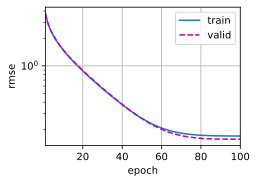

In [21]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)   
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')    

train log rmse 0.162640


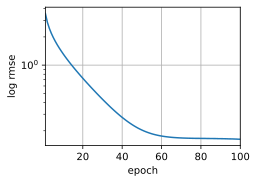

In [22]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)  
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
            ylabel = 'log rmse', xlim=[1,num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.cvs',index = False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)